Found 15 JSON files in: D:\CODE\cursor\End-Effector-Test-Environment\End-Effector-Test-Environment\Force Joystick\Collected Data\MH-Farhadi
Found 5 files for seed 0
Found 5 files for seed 2
Found 5 files for seed 58

Processing files in experiment order...

Mode 1: Manual (γ=0.0)

Processing: data_log_seed0_20250331_111622.json (Mode 1, Seed 0)
Found 23 trials in data_log_seed0_20250331_111622.json
Error processing file: name 'margin' is not defined

Processing: data_log_seed2_20250331_111853.json (Mode 1, Seed 2)
Found 32 trials in data_log_seed2_20250331_111853.json
Number of clusters: 9


C:\Users\tnlab\AppData\Local\Temp\ipykernel_20884\3282153630.py:251: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")
C:\Users\tnlab\AppData\Local\Temp\ipykernel_20884\3282153630.py:272: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")


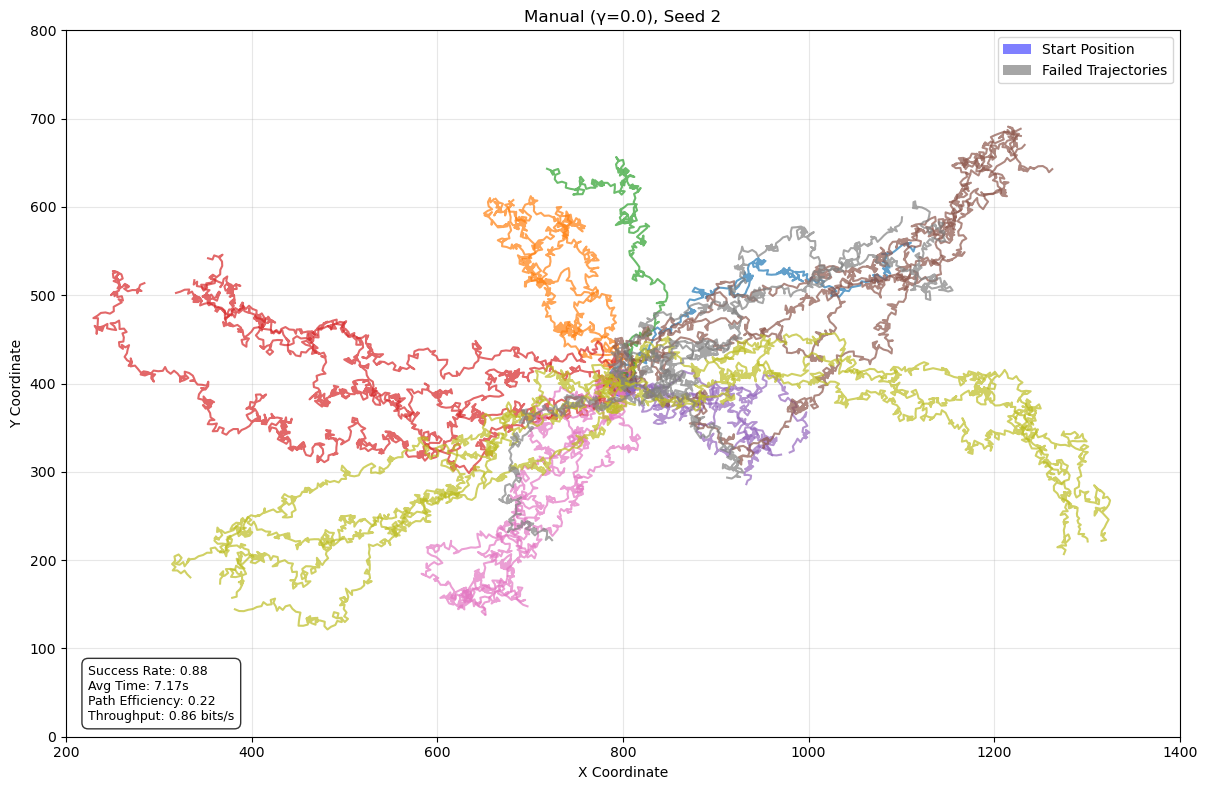

C:\Users\tnlab\AppData\Local\Temp\ipykernel_20884\3282153630.py:251: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")
C:\Users\tnlab\AppData\Local\Temp\ipykernel_20884\3282153630.py:272: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")



Processing: data_log_seed58_20250331_112243.json (Mode 1, Seed 58)
Found 26 trials in data_log_seed58_20250331_112243.json
Error processing file: name 'margin' is not defined

Mode 2: Balanced (γ=0.5)

Processing: data_log_seed0_20250331_112510.json (Mode 2, Seed 0)
Found 21 trials in data_log_seed0_20250331_112510.json
Error processing file: name 'margin' is not defined

Processing: data_log_seed2_20250331_112644.json (Mode 2, Seed 2)
Found 29 trials in data_log_seed2_20250331_112644.json
Number of clusters: 8


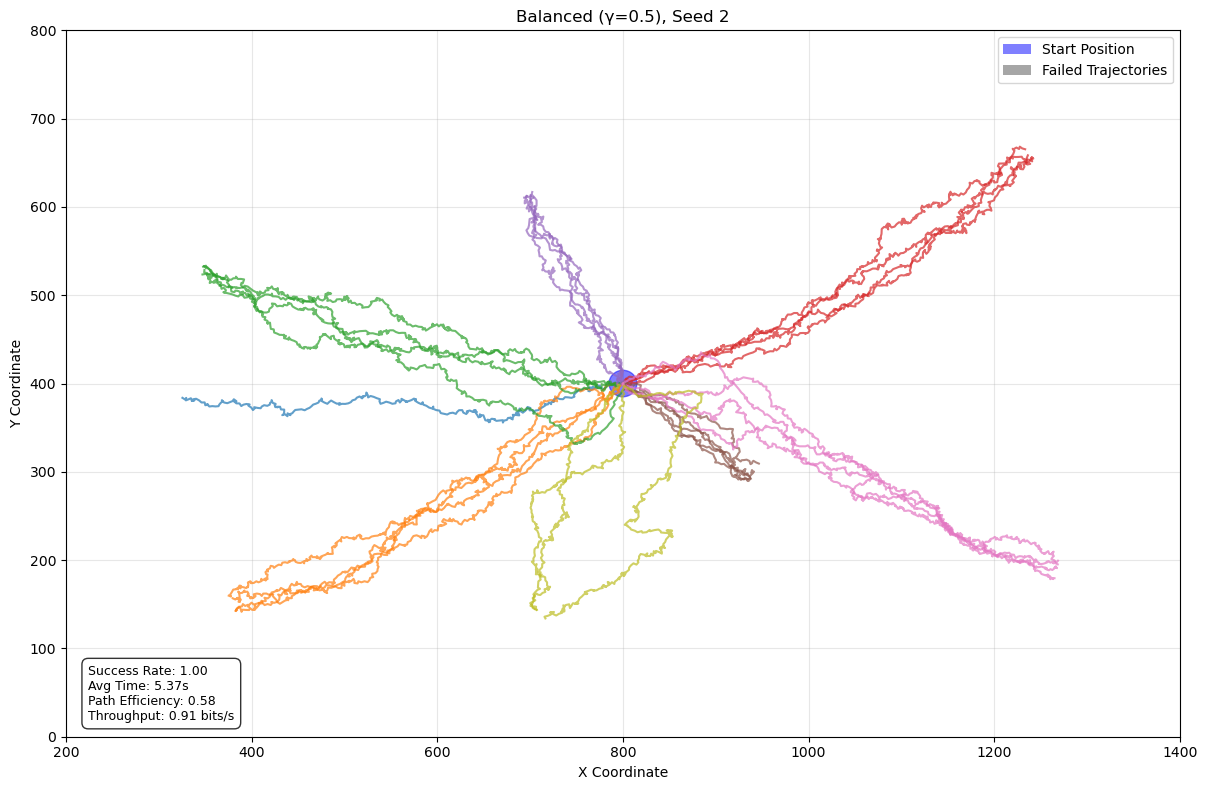

C:\Users\tnlab\AppData\Local\Temp\ipykernel_20884\3282153630.py:251: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")
C:\Users\tnlab\AppData\Local\Temp\ipykernel_20884\3282153630.py:272: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")



Processing: data_log_seed58_20250331_112918.json (Mode 2, Seed 58)
Found 24 trials in data_log_seed58_20250331_112918.json
Error processing file: name 'margin' is not defined

Mode 3: Automatic (γ=1.0)

Processing: data_log_seed0_20250331_113056.json (Mode 3, Seed 0)
Found 20 trials in data_log_seed0_20250331_113056.json
Error processing file: name 'margin' is not defined

Processing: data_log_seed2_20250331_113143.json (Mode 3, Seed 2)
Found 28 trials in data_log_seed2_20250331_113143.json
Number of clusters: 8


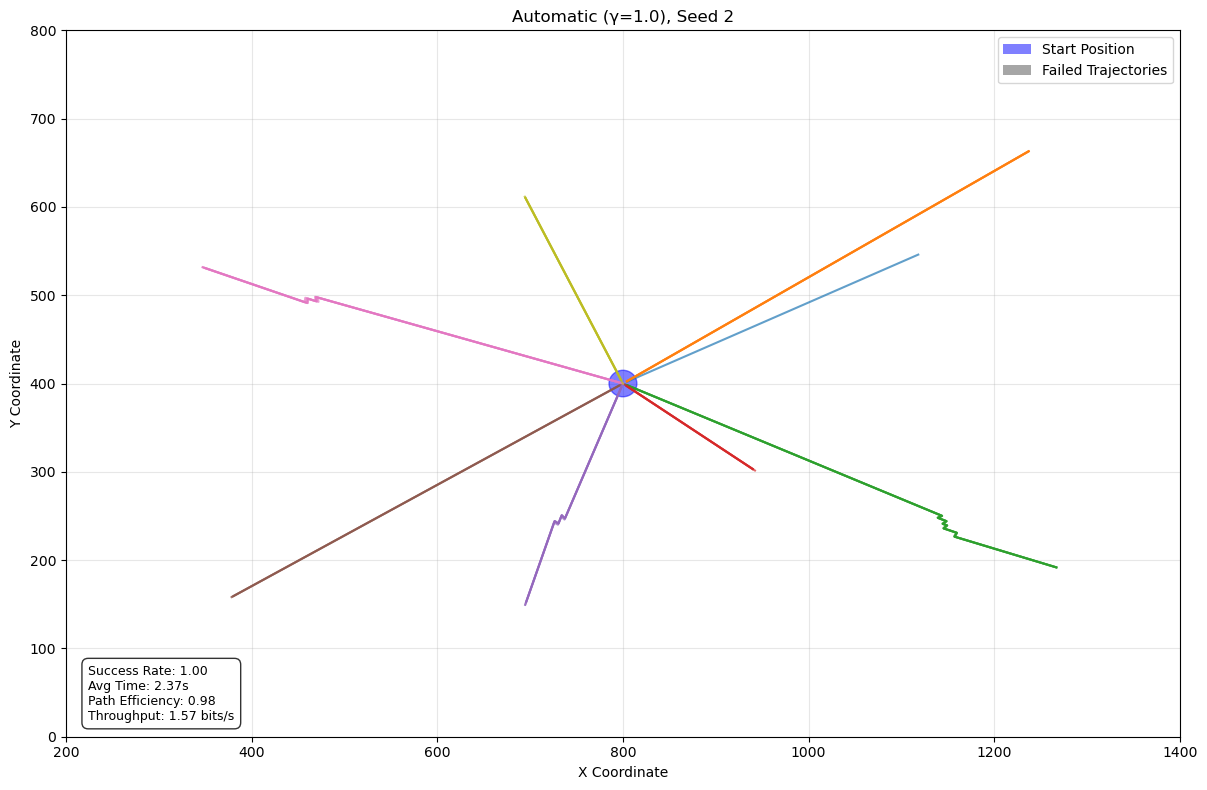


Processing: data_log_seed58_20250331_113249.json (Mode 3, Seed 58)
Found 24 trials in data_log_seed58_20250331_113249.json
Error processing file: name 'margin' is not defined

Mode 4: User-Controlled γ

Processing: data_log_seed0_20250331_113338.json (Mode 4, Seed 0)
Found 23 trials in data_log_seed0_20250331_113338.json
Error processing file: name 'margin' is not defined

Processing: data_log_seed2_20250331_113458.json (Mode 4, Seed 2)
Found 29 trials in data_log_seed2_20250331_113458.json
Number of clusters: 9


C:\Users\tnlab\AppData\Local\Temp\ipykernel_20884\3282153630.py:251: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")
C:\Users\tnlab\AppData\Local\Temp\ipykernel_20884\3282153630.py:272: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")


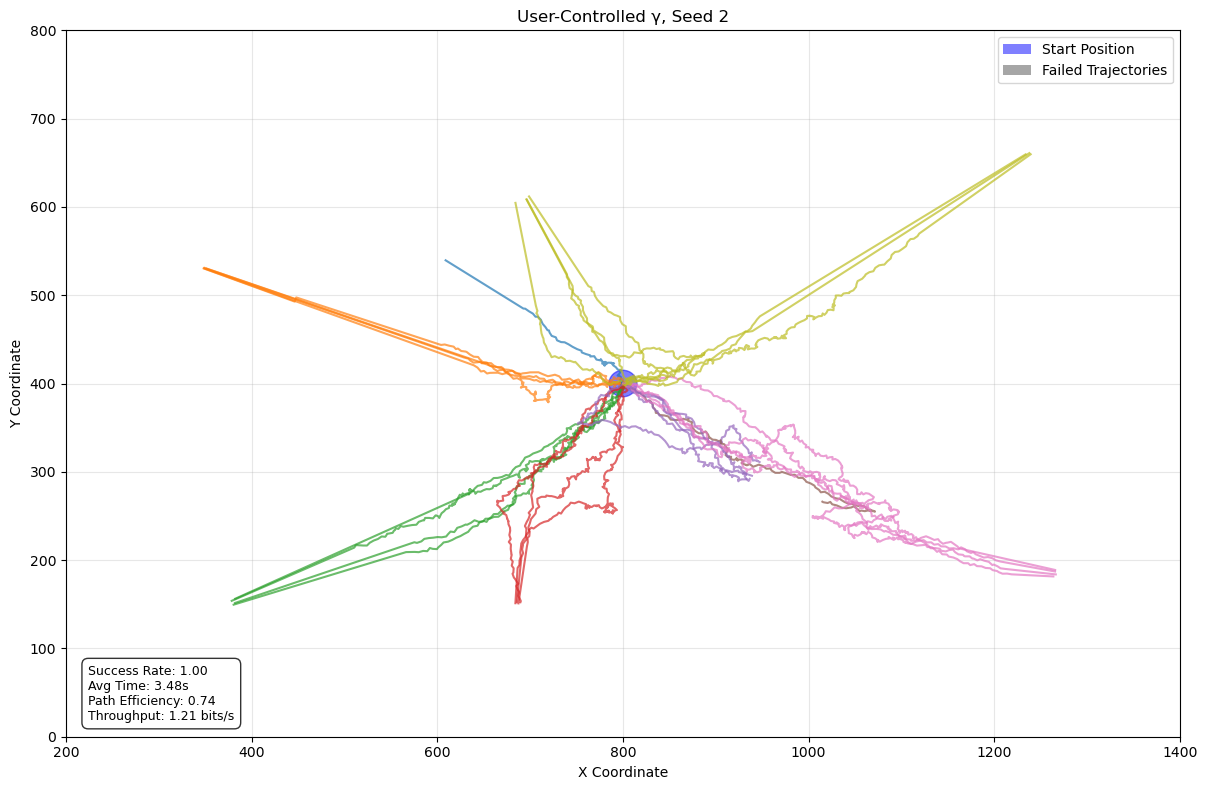

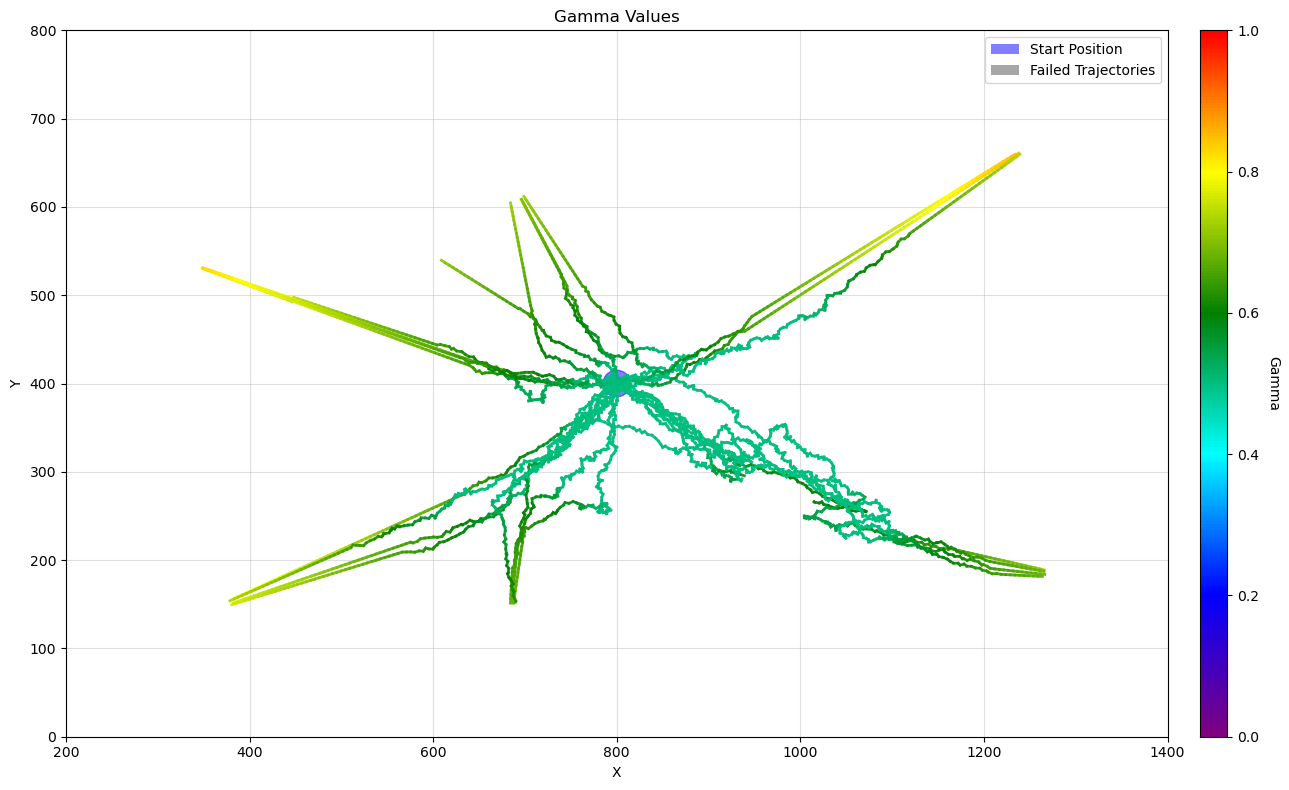


Processing: data_log_seed58_20250331_113640.json (Mode 4, Seed 58)
Found 28 trials in data_log_seed58_20250331_113640.json
Error processing file: name 'margin' is not defined

Mode 5: AI-Controlled γ

Processing: data_log_seed0_20250331_113803.json (Mode 5, Seed 0)
Found 20 trials in data_log_seed0_20250331_113803.json
Error processing file: name 'margin' is not defined

Processing: data_log_seed2_20250331_113901.json (Mode 5, Seed 2)
Found 31 trials in data_log_seed2_20250331_113901.json
Number of clusters: 8


C:\Users\tnlab\AppData\Local\Temp\ipykernel_20884\3282153630.py:251: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")
C:\Users\tnlab\AppData\Local\Temp\ipykernel_20884\3282153630.py:272: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")


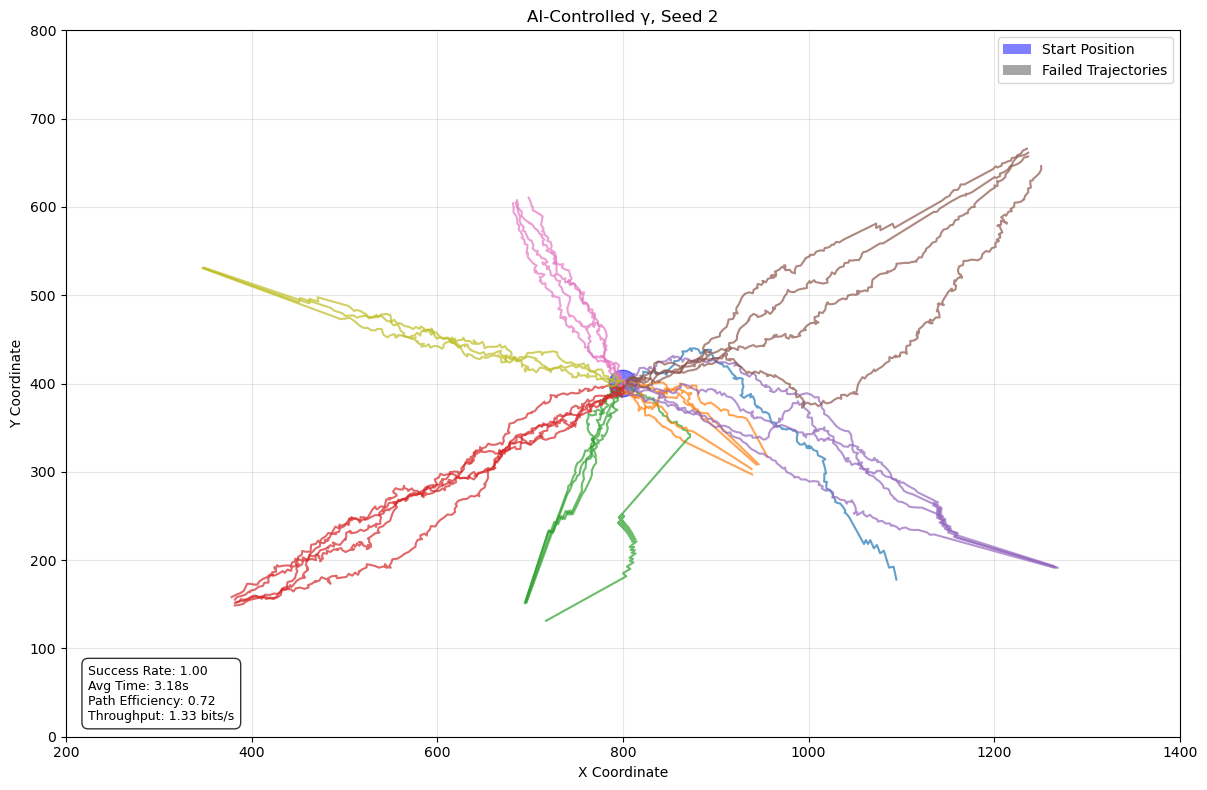

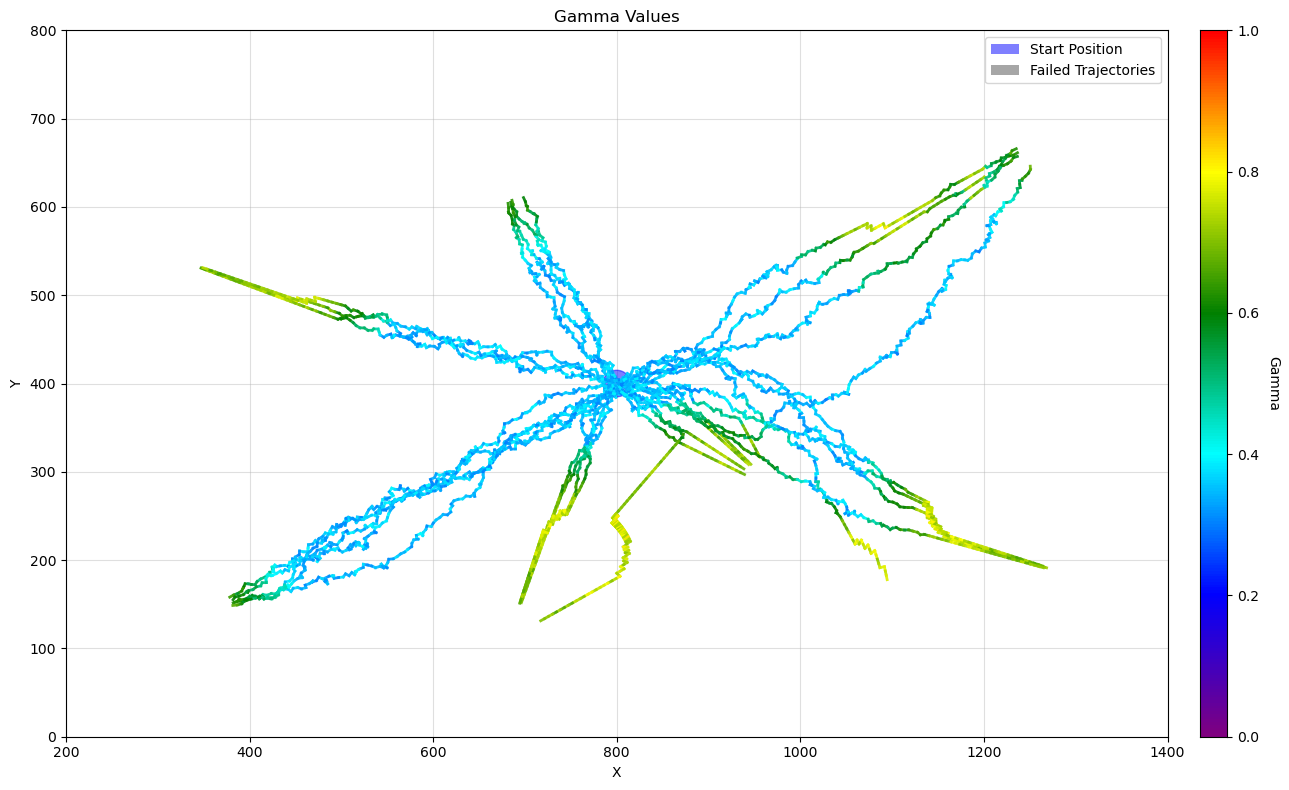


Processing: data_log_seed58_20250331_114039.json (Mode 5, Seed 58)
Found 24 trials in data_log_seed58_20250331_114039.json
Error processing file: name 'margin' is not defined

All analyses complete.


In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import defaultdict
import os
import re
from sklearn.cluster import DBSCAN
import random

# Helper function for distance calculation
def distance(pos1, pos2):
    return math.hypot(pos1[0] - pos2[0], pos1[1] - pos2[1])

def reproduce_environment(seed):
    """Directly reproduce the environment using the same logic as in the original experiment code."""
    # Constants from the original experiment code
    GAME_AREA_SIZE = (1200, 800)
    GAME_AREA_X = (1600 - 1200) // 2  # Calculated from FULL_VIEW_SIZE and GAME_AREA_SIZE
    GAME_AREA_Y = 0
    
    # Scaling factors
    OLD_WINDOW_SIZE = (600, 600)
    SCALING_FACTOR_X = GAME_AREA_SIZE[0] / OLD_WINDOW_SIZE[0]
    SCALING_FACTOR_Y = GAME_AREA_SIZE[1] / OLD_WINDOW_SIZE[1]
    SCALING_FACTOR = (SCALING_FACTOR_X + SCALING_FACTOR_Y) / 2
    
    # Game area center
    GAME_CENTER = (GAME_AREA_X + GAME_AREA_SIZE[0] // 2, GAME_AREA_Y + GAME_AREA_SIZE[1] // 2)
    START_POS = [GAME_CENTER[0], GAME_CENTER[1]]
    
    # Radius constants
    DOT_RADIUS = int(15 * SCALING_FACTOR)
    TARGET_RADIUS = int(10 * SCALING_FACTOR)
    OBSTACLE_RADIUS = int(10 * SCALING_FACTOR)
    COLLISION_BUFFER = int(5 * SCALING_FACTOR)
    
    # Special case for seed 2 - recreate the environment manually based on the image
    if seed == 2:
        targets = [
            (330, 150),     # Goal 2 - bottom left
            (950, 280),     # Goal 3 - right middle
            (650, 650),     # Goal 4 - top middle
            (300, 540),     # Goal 5 - top left
            (700, 110),     # Goal 6 - bottom middle
            (1200, 180),    # Goal 7 - bottom right 
            (950, 180)      # Goal 8 - end of blue line
        ]
        
        obstacles = [
            (540, 540),     # Upper left obstacle
            (780, 215),     # Bottom middle obstacle
            (900, 400),     # Right side obstacle for blue line to curve around
            (1050, 630),    # Top right obstacle
            (1150, 280)     # Bottom right obstacle
        ]
        
        return targets, obstacles, GAME_CENTER
    
    # For other seeds, use standard environment generation
    # Initialize random with the same seed
    random.seed(seed)
    np.random.seed(seed)
    
    # Generate goals (targets)
    targets = []
    attempts = 0
    while len(targets) < 8 and attempts < 1000:
        # Place goals within the game area
        x = random.uniform(GAME_AREA_X + margin, GAME_AREA_X + GAME_AREA_SIZE[0] - margin)
        y = random.uniform(GAME_AREA_Y + margin, GAME_AREA_Y + GAME_AREA_SIZE[1] - margin)
        candidate = (x, y)
        if all(distance(candidate, g) >= min_goal_gap for g in targets):
            targets.append(candidate)
        attempts += 1
    
    # Generate obstacles
    obstacles = []
    if len(targets) > 1:
        obstacle_goals = random.sample(targets, k=min(min(8-1, 5), len(targets)-1))
    else:
        obstacle_goals = targets.copy()
        
    for goal in obstacle_goals:
        t = random.uniform(0.6, 0.8)
        base_point = (START_POS[0] + t * (goal[0] - START_POS[0]),
                      START_POS[1] + t * (goal[1] - START_POS[1]))
        vec = (goal[0] - START_POS[0], goal[1] - START_POS[1])
        vec_norm = math.hypot(vec[0], vec[1])
        if vec_norm < 1e-6:
            perp = (0, 0)
        else:
            perp = (-vec[1] / vec_norm, vec[0] / vec_norm)
        offset_mag = random.uniform(20 * SCALING_FACTOR, 40 * SCALING_FACTOR)
        offset = (perp[0] * offset_mag * random.choice([-1,1]),
                  perp[1] * offset_mag * random.choice([-1,1]))
        candidate = (base_point[0] + offset[0], base_point[1] + offset[1])
        
        # Make sure obstacles are within game area
        candidate = (max(GAME_AREA_X + margin, min(candidate[0], GAME_AREA_X + GAME_AREA_SIZE[0] - margin)),
                    max(GAME_AREA_Y + margin, min(candidate[1], GAME_AREA_Y + GAME_AREA_SIZE[1] - margin)))
        
        valid = True
        if distance(candidate, START_POS) < (DOT_RADIUS + OBSTACLE_RADIUS + 10):
            valid = False
        if distance(candidate, goal) < (TARGET_RADIUS + OBSTACLE_RADIUS + 20):
            valid = False
        for obs in obstacles:
            if distance(candidate, obs) < (2 * OBSTACLE_RADIUS + 10):
                valid = False
        
        if valid:
            obstacles.append(candidate)
            
    return targets, obstacles, GAME_CENTER

# Set the path to your folder containing JSON files here
folder_path = r"D:\CODE\cursor\End-Effector-Test-Environment\End-Effector-Test-Environment\Force Joystick\Collected Data\MH-Farhadi"  # Change this to your folder path

def process_json_file(file_path, file_name, mode_num, env_seed):
    print(f"\nProcessing: {file_name} (Mode {mode_num}, Seed {env_seed})")
    
    # Load the JSON data from file
    try:
        with open(file_path, "r") as f:
            data_log = json.load(f)
        
        if not data_log:
            print("No trials found in data_log.")
            return
        else:
            print(f"Found {len(data_log)} trials in {file_name}")

            ###############################################################################
            # 0. REPRODUCE THE ORIGINAL ENVIRONMENT
            ###############################################################################
            # Reproduce the environment using the same logic as the original experiment
            original_targets, original_obstacles, start_pos = reproduce_environment(env_seed)
            
            # Use these as our reference for visualization
            targets = original_targets
            obstacles = original_obstacles

            ###############################################################################
            # 1. CALCULATE METRICS FOR THIS FILE
            ###############################################################################
            # Count successful trials for success rate
            total_trials = len(data_log)
            successful_trials = sum(1 for trial in data_log if trial.get("trial_outcome") == "success")
            success_rate = successful_trials / total_trials if total_trials > 0 else 0
            
            # Calculate metrics for successful trials
            completion_times = []
            path_efficiencies = []
            throughputs = []
            dot_diameter = 30.0  # DOT_RADIUS=15 from original code
            
            for trial in data_log:
                if trial.get("trial_outcome") != "success":
                    continue
                
                # Get completion time
                time = trial.get("trial_duration", 0)
                if time > 0:
                    completion_times.append(time)
                
                # Calculate path efficiency
                trajectory = trial.get("trajectory", [])
                if len(trajectory) >= 2:
                    # Calculate actual path length
                    path_length = 0.0
                    for i in range(len(trajectory) - 1):
                        x1, y1 = trajectory[i][0], trajectory[i][1]
                        x2, y2 = trajectory[i+1][0], trajectory[i+1][1]
                        path_length += math.hypot(x2 - x1, y2 - y1)
                    
                    # Calculate direct distance
                    start_x, start_y = trajectory[0][0], trajectory[0][1]
                    end_x, end_y = trajectory[-1][0], trajectory[-1][1]
                    direct_dist = math.hypot(end_x - start_x, end_y - start_y)
                    
                    # Path efficiency
                    if path_length > 0:
                        path_eff = direct_dist / path_length
                        path_efficiencies.append(path_eff)
                    
                    # Fitts' throughput
                    if time > 0 and path_length > 0:
                        ID = math.log2(path_length / dot_diameter + 1.0)
                        throughput = ID / time
                        throughputs.append(throughput)
            
            # Calculate averages
            avg_completion_time = np.mean(completion_times) if completion_times else 0
            avg_path_efficiency = np.mean(path_efficiencies) if path_efficiencies else 0
            avg_throughput = np.mean(throughputs) if throughputs else 0
            
            ###############################################################################
            # 2. IMPROVED CLUSTERING FOR TRAJECTORY ENDPOINTS
            ###############################################################################
            # Analyze and process trajectories
            trajectories = []
            
            for trial in data_log:
                trajectory = trial.get("trajectory", [])
                outcome = trial.get("trial_outcome")
                
                if not trajectory or len(trajectory) < 2:
                    continue
                
                # Store the trajectory data
                traj_data = {
                    "trajectory": trajectory,
                    "outcome": outcome
                }
                trajectories.append(traj_data)
            
            # If there are enough trajectories, cluster by endpoints
            successful_trajectories = [t for t in trajectories if t["outcome"] == "success"]
            if len(successful_trajectories) >= 2:
                # Extract endpoints from successful trajectories
                endpoints = []
                for traj in successful_trajectories:
                    trajectory = traj["trajectory"]
                    end_x, end_y = trajectory[-1][0], trajectory[-1][1]
                    endpoints.append([end_x, end_y])
                
                # Convert to numpy array
                endpoints_array = np.array(endpoints)
                
                # Use DBSCAN for clustering with appropriate epsilon
                db = DBSCAN(eps=50, min_samples=1).fit(endpoints_array)
                
                # Get cluster labels
                labels = db.labels_
                
                # Assign cluster labels to trajectories
                cluster_idx = 0
                for i, traj in enumerate(trajectories):
                    if traj["outcome"] == "success":
                        traj["cluster"] = int(labels[cluster_idx])
                        cluster_idx += 1
                    else:
                        traj["cluster"] = -1  # Failed trajectories get -1
                
                # Count number of unique clusters (excluding -1)
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                print(f"Number of clusters: {n_clusters}")
                
                # Assign colors to clusters
                cmap = plt.cm.get_cmap("tab10")
                cluster_colors = {}
                for i in range(n_clusters):
                    cluster_colors[i] = cmap(i % 10)
                
                ###############################################################################
                # 3. PLOT TRAJECTORIES WITH IMPROVED COLORING AND INCLUDE GOALS/OBSTACLES
                ###############################################################################
                plt.figure(figsize=(12, 8))
                
                # Draw the start position
                GAME_AREA_SIZE = (1200, 800)
                GAME_AREA_X = 200
                GAME_AREA_Y = 0
                GAME_CENTER = (GAME_AREA_X + GAME_AREA_SIZE[0] // 2, GAME_AREA_Y + GAME_AREA_SIZE[1] // 2)
                DOT_RADIUS = 15
                start_circle = plt.Circle(GAME_CENTER, DOT_RADIUS, color='blue', 
                                         alpha=0.5, zorder=2, label='Start Position')
                plt.gca().add_patch(start_circle)
                
                # Plot successful trajectories by cluster with colors other than gray
                cmap = plt.cm.get_cmap("tab10")
                cluster_colors = {}
                for i in range(n_clusters):
                    # Skip gray-like colors (use more vibrant colors)
                    color = cmap(i % 10)
                    # Skip gray-like colors
                    if 0.2 < color[0] < 0.5 and 0.2 < color[1] < 0.5 and 0.2 < color[2] < 0.5:
                        color = cmap((i+1) % 10)  # Skip this color
                    cluster_colors[i] = color
                
                # Plot successful trajectories by cluster
                for traj in trajectories:
                    if traj["outcome"] == "success":
                        cluster = traj["cluster"]
                        color = cluster_colors.get(cluster, 'blue')  # Default to blue if no cluster
                        
                        trajectory = traj["trajectory"]
                        xs = [pt[0] for pt in trajectory]
                        ys = [pt[1] for pt in trajectory]
                        
                        plt.plot(xs, ys, color=color, linewidth=1.5, alpha=0.7, zorder=3)
                
                # Plot collision trajectories in gray
                for traj in trajectories:
                    if traj["outcome"] == "collision":
                        trajectory = traj["trajectory"]
                        xs = [pt[0] for pt in trajectory]
                        ys = [pt[1] for pt in trajectory]
                        
                        plt.plot(xs, ys, color='gray', linewidth=1.5, alpha=0.7, zorder=3)
                
                # Plot failed (but not collision) trajectories in gray
                for traj in trajectories:
                    if traj["outcome"] != "success" and traj["outcome"] != "collision":
                        trajectory = traj["trajectory"]
                        xs = [pt[0] for pt in trajectory]
                        ys = [pt[1] for pt in trajectory]
                        
                        plt.plot(xs, ys, color='gray', linewidth=1.5, alpha=0.7, zorder=3)
                
                # Add metrics text box
                metrics_text = (
                    f"Success Rate: {success_rate:.2f}\n"
                    f"Avg Time: {avg_completion_time:.2f}s\n"
                    f"Path Efficiency: {avg_path_efficiency:.2f}\n"
                    f"Throughput: {avg_throughput:.2f} bits/s"
                )
                
                # Add text box with metrics
                plt.annotate(metrics_text, xy=(0.02, 0.02), xycoords='axes fraction',
                            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
                            fontsize=9, verticalalignment='bottom')
                
                # Get correct mode name
                mode_names = {
                    1: "Manual (γ=0.0)",
                    2: "Balanced (γ=0.5)",
                    3: "Automatic (γ=1.0)",
                    4: "User-Controlled γ",
                    5: "AI-Controlled γ"
                }
                mode_name = mode_names.get(mode_num, f"Mode {mode_num}")
                
                plt.xlabel("X Coordinate")
                plt.ylabel("Y Coordinate")
                plt.title(f"{mode_name}, Seed {env_seed}")
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                
                # Add legend for start position and trajectory types
                from matplotlib.patches import Patch
                legend_elements = [
                    Patch(facecolor='blue', alpha=0.5, label='Start Position'),
                    Patch(facecolor='gray', alpha=0.7, label='Failed Trajectories')
                ]
                plt.legend(handles=legend_elements, loc='upper right')
                
                # Set axis limits to match the game area in original code
                plt.xlim(200, 1400)  # Game area X range: 200 to 1400
                plt.ylim(0, 800)     # Game area Y range: 0 to 800
                
                # Display the plot
                plt.show()
                
                ###############################################################################
                # 4. PLOT GAMMA VALUES ALONG TRAJECTORY (ONLY FOR MODES 4 AND 5)
                ###############################################################################
                if mode_num in [4, 5]:
                    # Create figure with gridspec for main plot and colorbar
                    fig = plt.figure(figsize=(13, 8))
                    gs = fig.add_gridspec(1, 20)  # 20 columns
                    ax1 = fig.add_subplot(gs[0, 0:19])  # Main plot takes 19 columns
                    ax2 = fig.add_subplot(gs[0, 19:20])  # Colorbar takes 1 column
                    
                    # Use coolwarm colormap but bias it toward cooler colors
                    from matplotlib.colors import LinearSegmentedColormap
                    
                    # Create a custom colormap with more emphasis on blue to green range
                    # Start with blues/purples, move through greens, then to yellows/reds
                    colors = [(0.0, "purple"), 
                            (0.2, "blue"),
                            (0.4, "cyan"),
                            (0.6, "green"),
                            (0.8, "yellow"),
                            (1.0, "red")]
                    custom_cmap = LinearSegmentedColormap.from_list("custom_gamma", colors)
                    
                    # Draw start position in gamma plot
                    DOT_RADIUS = 15
                    start_circle = plt.Circle(GAME_CENTER, DOT_RADIUS, color='blue', 
                                           alpha=0.5, zorder=2, label='Start Position')
                    ax1.add_patch(start_circle)
                    
                    # Plot trajectories with gamma coloring on main plot
                    for traj in trajectories:
                        if traj["outcome"] == "success":
                            trajectory = traj["trajectory"]
                            
                            # Extract gamma values
                            xs = []
                            ys = []
                            gs = []
                            
                            for step in trajectory:
                                if len(step) >= 3:
                                    x, y, g = step[0], step[1], step[2]
                                    xs.append(x)
                                    ys.append(y)
                                    gs.append(g)
                            
                            # Plot line segments with color based on gamma
                            for i in range(len(xs) - 1):
                                ax1.plot([xs[i], xs[i+1]], [ys[i], ys[i+1]], 
                                        color=custom_cmap(gs[i]), linewidth=2.0, alpha=0.9)
                        
                        # Plot failed trajectories in gray
                        elif traj["outcome"] != "success":
                            trajectory = traj["trajectory"]
                            
                            # Extract coordinates
                            xs = [pt[0] for pt in trajectory]
                            ys = [pt[1] for pt in trajectory]
                            
                            # Plot failed trajectory in gray
                            ax1.plot(xs, ys, color='gray', linewidth=1.5, alpha=0.7)
                    
                    # Set up the main plot
                    ax1.set_xlabel("X")
                    ax1.set_ylabel("Y")
                    ax1.set_title("Gamma Values")
                    ax1.grid(True, alpha=0.4)
                    ax1.set_xlim(200, 1400)  # Match game area X range
                    ax1.set_ylim(0, 800)     # Match game area Y range
                    
                    # Create the standalone colorbar in the separate axis
                    # Create a gradient image for the colorbar
                    gradient = np.linspace(0, 1, 256)
                    gradient = np.vstack((gradient, gradient))
                    
                    # Display the gradient image on the colorbar axis
                    ax2.imshow(gradient.T, aspect='auto', cmap=custom_cmap, 
                            extent=[0, 1, 0, 1], origin='lower')
                    
                    # Set colorbar ticks and labels
                    ax2.set_xticks([])  # No horizontal ticks
                    ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
                    ax2.set_yticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
                    ax2.set_ylabel('Gamma', rotation=270, labelpad=15)
                    ax2.yaxis.set_label_position("right")
                    ax2.yaxis.tick_right()
                    
                    # Add legend for trajectory types
                    from matplotlib.patches import Patch
                    legend_elements = [
                        Patch(facecolor='blue', alpha=0.5, label='Start Position'),
                        Patch(facecolor='gray', alpha=0.7, label='Failed Trajectories')
                    ]
                    ax1.legend(handles=legend_elements, loc='upper right')
                    
                    plt.tight_layout()
                    plt.show()
            
            else:
                print("Not enough successful trajectories to perform clustering.")
            
    except json.JSONDecodeError:
        print(f"Error decoding JSON from file: {file_path}")
    except Exception as e:
        print(f"Error processing file: {e}")


# Main execution code
if __name__ == "__main__":
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
    else:
        # Get all JSON files in the folder
        json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]
        
        if not json_files:
            print(f"No JSON files found in: {folder_path}")
        else:
            print(f"Found {len(json_files)} JSON files in: {folder_path}")
            
            # Define correct experiment structure based on original code
            gamma_modes = [0.0, 0.5, 1.0, "manual", "ai"]  # Original modes from code
            mode_numbers = [1, 2, 3, 4, 5]                 # Corresponding mode numbers
            seeds = [0, 2, 58]                            # Seeds used in original experiment
            
            # Extract and organize files
            all_files = []
            
            for filename in json_files:
                # Extract seed number
                seed_match = re.search(r'seed(\d+)', filename)
                if not seed_match:
                    continue
                    
                seed = int(seed_match.group(1))
                if seed not in seeds:
                    continue
                
                # Extract timestamp
                time_match = re.search(r'_(\d+)\.json$', filename)
                if not time_match:
                    continue
                
                timestamp = time_match.group(1)
                
                all_files.append({
                    'filename': filename,
                    'seed': seed,
                    'timestamp': timestamp
                })
            
            # Group files by seed
            files_by_seed = {}
            for seed in seeds:
                seed_files = [f for f in all_files if f['seed'] == seed]
                # Sort by timestamp
                seed_files.sort(key=lambda x: x['timestamp'])
                files_by_seed[seed] = seed_files
            
            # Check if we have enough files for each seed
            for seed in seeds:
                if seed in files_by_seed:
                    print(f"Found {len(files_by_seed[seed])} files for seed {seed}")
                    # We should have at least 5 files (one for each mode)
                    if len(files_by_seed[seed]) < 5:
                        print(f"Warning: Expected at least 5 files for seed {seed}, found {len(files_by_seed[seed])}")
            
            # Process in order of the original experiment: by mode first, then by seed
            print("\nProcessing files in experiment order...")
            
            for mode_idx, mode_num in enumerate(mode_numbers):
                # Get descriptive mode name
                mode_names = {
                    1: "Manual (γ=0.0)",
                    2: "Balanced (γ=0.5)",
                    3: "Automatic (γ=1.0)",
                    4: "User-Controlled γ",
                    5: "AI-Controlled γ"
                }
                mode_name = mode_names.get(mode_num, f"Mode {mode_num}")
                print(f"\nMode {mode_num}: {mode_name}")
                
                # For each seed in this mode
                for seed in seeds:
                    # Make sure we have files for this seed
                    if seed not in files_by_seed or not files_by_seed[seed]:
                        print(f"No files found for seed {seed}")
                        continue
                    
                    # Get file for this mode (fifth file = mode 5, etc.)
                    if mode_idx < len(files_by_seed[seed]):
                        file_data = files_by_seed[seed][mode_idx]
                        file_path = os.path.join(folder_path, file_data['filename'])
                        process_json_file(file_path, file_data['filename'], mode_num, seed)
                    else:
                        print(f"No file found for Mode {mode_num}, Seed {seed}")
            
            print("\nAll analyses complete.")